# activations, gradients, and batchnorm

## papers
- Kaiming init paper - [Delving Deep into Rectifiers](https://arxiv.org/pdf/1502.01852)
- [Batch Normalization](https://arxiv.org/pdf/1502.03167)
- [Rethinking "Batch" in BatchNorm](https://arxiv.org/pdf/2105.07576)
- [Batch Norm Explained blog](https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739/)

# Kaiming init
- The Kaiming paper stated that a bad initilization can still hamper the learning of a highly non-linear system. 
- So they proposed a robust initialization method for extremely deep models.
- more notes on this in future cell 

# Normalizing Input Data
- It is standard practice to normalize the data to zero mean and unit variance.
- This ensures that all feature values are now on the same scale. Then gradient descent will converge better during training.

# BatchNorm (BN) - training
- The need for batch normalization is similar. Normalizing the activations from each previous layer helps gradient descent converge better during training.
- BatchNorm is a technique to improve training speed and stability in deep neural networks. It is another network layer that gets inserted between a hidden layer and the next hidden layewr.
- Recent literature states to place the BN layer after activation.
- This is standard in CNNs, RNNs, and Transformers and is widely used in frameworks like PyTorch. 
- Similar techniques like LayerNorm, GroupNorm, and InstanceNorm are used in different architectures.
- Just like a network's parameters (weights, bias), the Batch Norm layer also has its own parameters gamma and beta. 
- It also has two non-learnable parameters: the mean moving average and the variance moving average as part of its state.
---

BN **normalize activations** using:
```math
\hat{x}^{(k)} = \frac{ x^{(k)} - \mu_{B} }{ \sqrt{ \sigma_{B}^2 + \epsilon } }
```
where $\mu_{B}$ and $\sigma_{B}^2$ is the mean and variance of the mini-batch and $\epsilon$ prevents division by zero.

The normalized activation is them **scaled and shifted** with learnable parameters. Use this to calculate the output.
```math
y^{(k)} = \gamma \hat{x}^{(k)} + \beta
```
where $\gamma$ and $\beta$ allow the learnable parameters that allow the network to retain representational power. This is an element-wise multiply.

---

- Batch Norm allows its values to be shifted (to a different mean) and scaled (to a different variance).
- $\gamma$ and $\beta$ are not hyperparameters, but trainable parameters. The network learns these parameters for itself to get the best predictions.

# BatchNorm - inference
- The moving average and moving variance are caculated during training but not used in training. They are only used during the inference phase.
- The moving average calculation uses a scalar "momentum". This is a hyperparameter used only for BatchNorm moving averages.
- The moving average (calculated based on batches during training) acts a good proxy for the mean and variance of the data. This is also much more efficient.

In [120]:
import torch
import torch.nn.functional as F
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
import random
random.seed(42)

In [121]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print("first 5 words:", words[:5])

# build the vocabulary of characters
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(f'{itos=}')
print(f'{vocab_size=}')

# buold the dataset and process it
block_size = 3  # context_length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []
    for word in words:
        context = [0] * block_size
        for ch in word + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

random.shuffle(words)
num_words = len(words)
n1 = int(0.8*num_words)
n2 = int(0.9*num_words)
 
Xtr, Ytr = build_dataset(words[:n1])      # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])      # 10%

first 5 words: ['emma', 'olivia', 'ava', 'isabella', 'sophia']
itos={1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
vocab_size=27


number of parameters: 11897
expected initial negative log loss tensor(3.2958) 

      0/   2000: loss is 27.8817
    500/   2000: loss is 6.7759
   1000/   2000: loss is 4.0136
   1500/   2000: loss is 3.7800

h.shape=torch.Size([32, 200]), h.min()=tensor(-1., grad_fn=<MinBackward1>), h.max()=tensor(1., grad_fn=<MaxBackward1>)


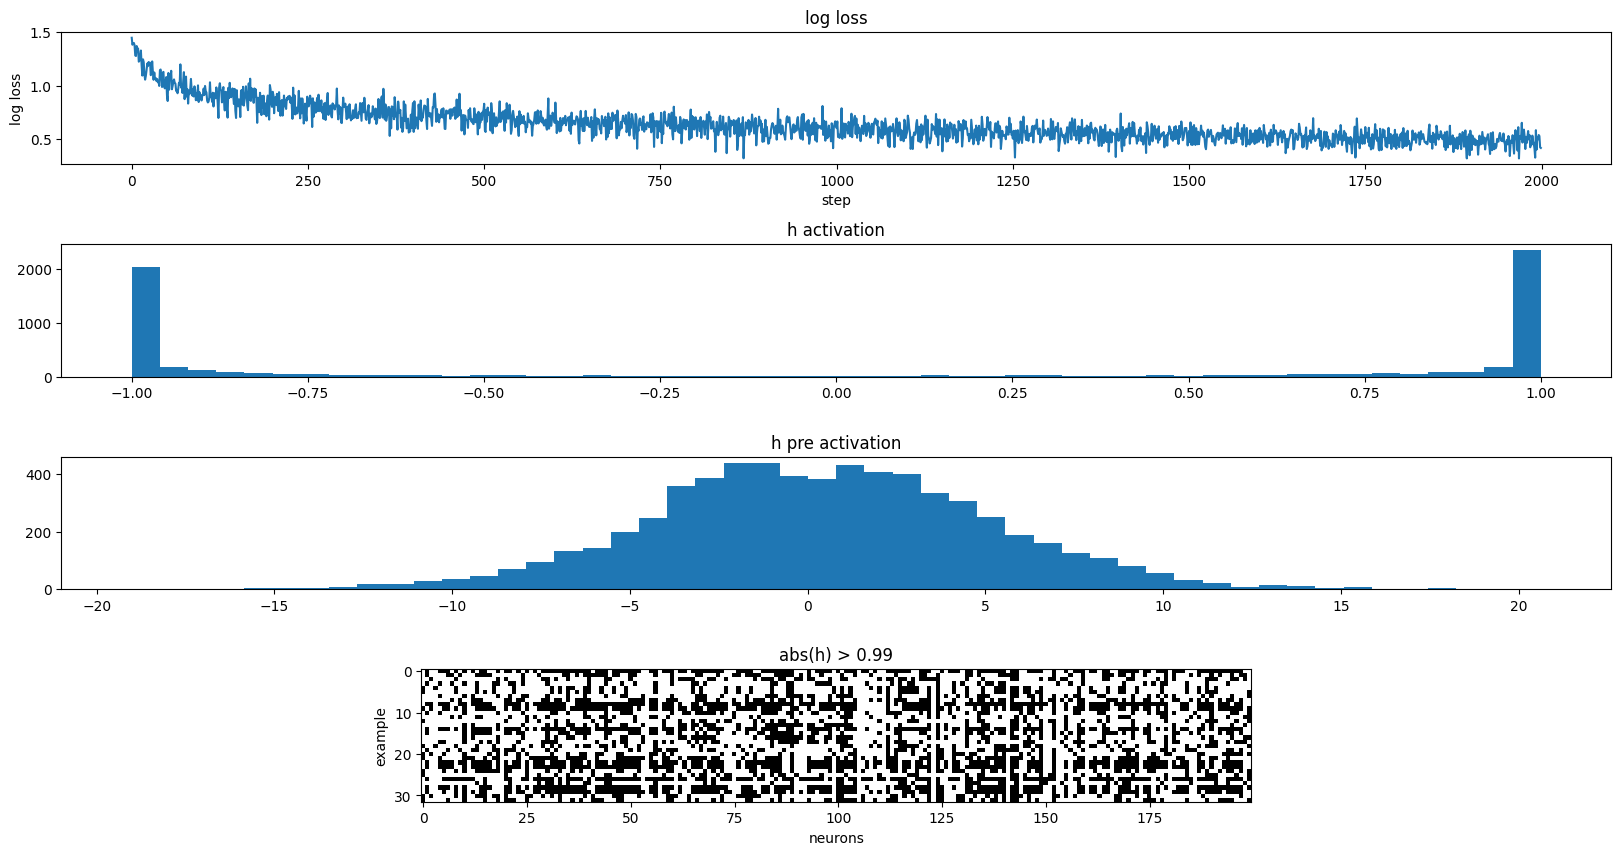

In [122]:
# BEFORE APPLYING BATCHNORM
def MLP_revisited_no_bn():
    # MLP revisited
    n_embd = 10  # the dimensionality of the character embedding vectors
    n_hidden = 200  # the number of neurons in the hidden layer of the MLP

    # we need a principled way to set scales...

    g = torch.Generator().manual_seed(2147483647)
    C = torch.randn((vocab_size, n_embd), generator=g)
    W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
    b1 = torch.randn(n_hidden, generator=g)
    W2 = torch.randn((n_hidden, vocab_size), generator=g)
    b2 = torch.randn(vocab_size, generator=g) 

    parameters = [C, W1, b1, W2, b2]
    print("number of parameters:", sum(p.nelement() for p in parameters))
    for p in parameters:
        p.requires_grad=True

    print("expected initial negative log loss", -torch.tensor(1/27.0).log(), "\n")

    # optimizations from part 2
    max_steps = 2000
    batch_size = 32
    stepi = []
    lossi = []

    for i in range(max_steps):
        # minibatch construct
        ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
        Xb, Yb = Xtr[ix], Ytr[ix]  # batch X, Y

        # forward pass
        emb = C[Xb]  # embed the characters into vectors
        embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors
        # Linear layer
        hpreact = embcat @ W1 + b1  # hidden layer pre-activation
        # Non-linearity
        h = torch.tanh(hpreact)  # hidden layer
        logits = h @ W2 + b2  # output layer
        loss = F.cross_entropy(logits, Yb)  # loss function

        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()

        # update
        lr = 0.1
        for p in parameters:
            p.data += -lr * p.grad
        
        # track stats
        if i % 500 == 0:  # print every once in a while
            print(f'{i:7d}/{max_steps:7d}: loss is {loss.item():.4f}')
        stepi.append(i)
        lossi.append(loss.log10().item())

    fig, axes = plt.subplots(4, 1, figsize=(20,10))
    plt.subplots_adjust(hspace=0.6)
    axes[0].plot(stepi, lossi)
    axes[0].set_xlabel("step")
    axes[0].set_ylabel("log loss")
    axes[0].set_title("log loss")

    """
    h activation plot
    - most values take on the value of -1 and 1
    - this tanh distribution should make you sweat! if most values are either at -1 or 1, which effectively kill sthe back propgration in the backward pass
    - tanh, if output is 1, we are at the tail (flat region), so changing the input will not impact the tanh too much, aka loss is not impacted
    - if all outputs of h are in flat regions -1 and 1 then gradients flowing through here disappear
    """
    axes[1].hist(h.view(-1).tolist(), 50)
    axes[1].set_title('h activation')
    print(f'\n{h.shape=}, {h.min()=}, {h.max()=}')  # 32 examples, 200 neurons for each example
    """
    h pre activation plot
    - this distribution is broad, values between -15 and 15
    - it is too large, too saturated, which means there is less training for the neurons, they activate less frequently
    """
    axes[2].hist(hpreact.view(-1).tolist(), 50)
    axes[2].set_title('h pre activation')
    """
    abs(h) > 0.99 plot
    - this is a boolean tensor, white if true and black if false
    - for any of these 200 neurons, if the whole column is white, then given the wieghts and baises, no single example ever activates this tanh in the active part of the tanh
    - if all examples land in the tail, it is a dead neuron
    - if have a case where you did get a dead neuron, no matter the inputs, the neuron would produce 1 or -1 and would never learn
    - sigmoid function is also a squashing function like tanh, reLU function also has a flat region
    - got this model, if way too many examples take on extreme values, -1 or 1, this is not optimal, especially at initialization
    """
    axes[3].imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest")
    axes[3].set_title('abs(h) > 0.99')
    axes[3].set_xlabel('neurons')
    axes[3].set_ylabel('example')

MLP_revisited_no_bn()

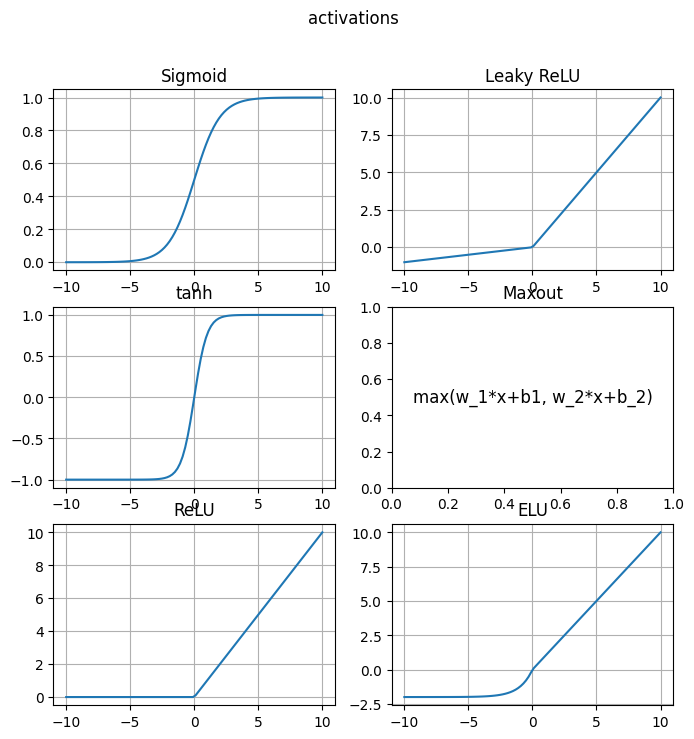

In [123]:
def activation_types_plots():
    fig2, axes2 = plt.subplots(3, 2)  # 3 rows, 2 cols
    fig2.set_size_inches(8, 8)
    fig2.suptitle('activations')
    x = np.linspace(-10, 10, 100)
    axes2[0, 0].plot(x, 1 / (1 + np.exp(-x)))
    axes2[0, 0].grid(visible=True)
    axes2[0, 0].set_title('Sigmoid')
    axes2[1, 0].plot(x, np.tanh(x))
    axes2[1, 0].grid(visible=True)
    axes2[1, 0].set_title('tanh')
    axes2[2, 0].plot(x, np.maximum(0, x))
    axes2[2, 0].grid(visible=True)
    axes2[2, 0].set_title('ReLU')
    axes2[0, 1].plot(x, np.maximum(0.1*x, x))
    axes2[0, 1].grid(visible=True)
    axes2[0, 1].set_title('Leaky ReLU')
    axes2[1, 1].text(0.5, 0.5, "max(w_1*x+b1, w_2*x+b_2)", ha="center", va="center", fontsize=12)
    axes2[1, 1].set_title('Maxout')
    axes2[2, 1].plot(x, np.where(x > 0, x, 2.0 * (np.exp(x) - 1)))
    axes2[2, 1].grid(visible=True)
    axes2[2, 1].set_title('ELU')

activation_types_plots()

# INITIAL LOSS - aka initial logits
- an initial loss of 27 is way too high
- when training neural nets, you will have a rough idea for what loss to expect at initialization
- that depends on the loss function and problem setup, we can calculate it
- there's 27 characters, since training hasn't occurred yet, we expect a uniform distribution of probabilities for all 27 characters
- so we want the probabolity for any character to be 1/27 at initial
- the loss is the negative log probability
- so we should expect an initial loss of 3.2958
- we want the logits to be roughly zero to start with
- or at least just equal
- how do we achieve this? logits = h @ W2 + b2
- let's have b2 be 0s at initialization
- scale down W2, but don't set it to 0
- don't set Ws to 0

# VALUES OF H, the hidden state
- h, this is the tanh function, squashes all the values between -1 and 1 inclusive
- if values of h are mostly -1 and 1, it is too saturated, and there will be less training for the neurons, since they will activate less frequently
- hpreact is embcat, which comes from C
- hpreact is too far off from zero, we want this to be closer to zero, similar to what we needed for logits
- let's scale down b1 to 0.01
- let's squash W1 as well to 0.01

# SMALL MODEL
- this one layer model is shallow and optimization is quite easy
- much deeper layers with 50 or so layers, problems can stack up, a model won't train at all if not initialized correctly

# KAIMING INIT: calculating the init scale
- how to set scale numbers on input parameters
- see paper: Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classifications by Kaiming He
- https://arxiv.org/pdf/1502.01852 
- they study a convolutional neural network, ReLU nonlinearity, positive numbers pass thru and negative numbers go to 0
- since half the inputs are thrown out and clamped to zero, they use a gain 
- this paper studies the forward pass and the back propagation, keeping gradients well behaved
- they find that if you properly initialize the forward pass, the backward pass is also approximately initialized up to a constant factor (due to size of number of hidden neurons)
- they find emprically that it is not a choice that matters much
- see pytorch init kaiming_normal function - https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_
- **this is the most commmon way to init neural networks now**
- args - a mode - normalize the activations or gradients. usually people use the default
- args - the nonlinearity you are using in order to calculate the gain
- in this ipynb model, set W1 scale to (5/3) / ((n_emb * block_size)** 0.5)

x.mean()=tensor(0.0114), x.std()=tensor(0.9955)
y.mean()=tensor(0.0015), y.std()=tensor(0.9812)


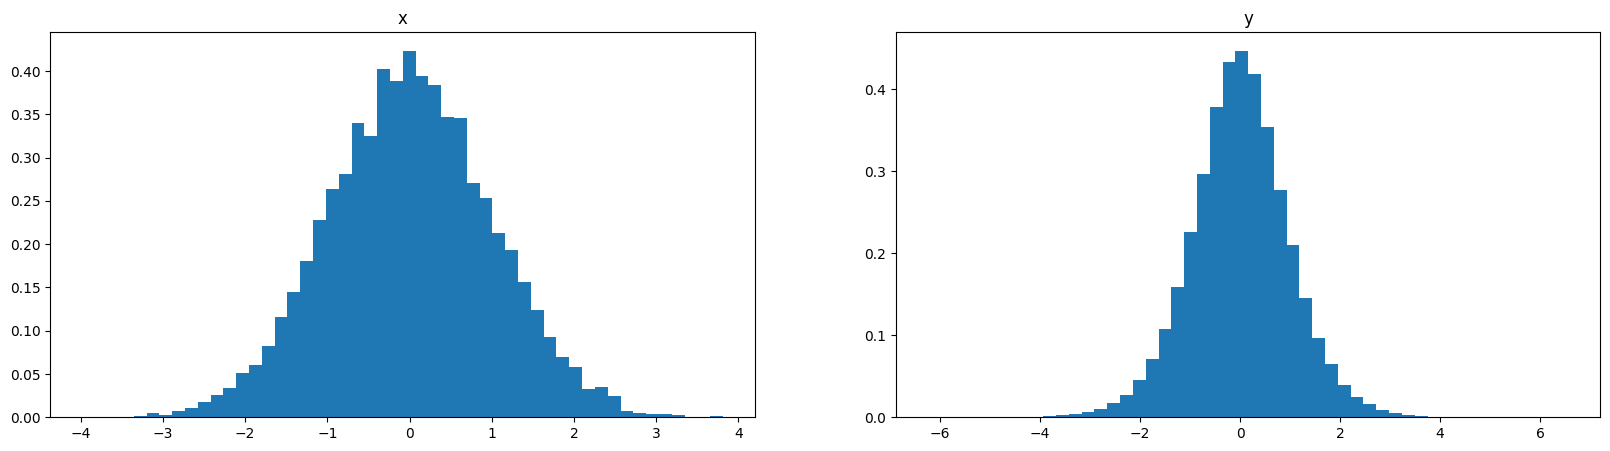

In [145]:
def exercise_scale():
    #w_scale = 5  # this causes the gaussian std to grow and grow, so output y take more extreme values
    #w_scale = 0.2  # this causes the gaussian std to get smaller and smaller, it's shrinking
    # how to pick a w_scale to get a y std dev of exactly 1??
    # DIVIDE w by the sqrt of 10 -> now output gaussian will have a std dev of 1, yay!
    w_scale = 1 / 10**0.5
    x = torch.randn(1000, 10)  # init using uniform gaussian
    w = torch.randn(10, 200) * w_scale # init using uniform gaussian
    y = x @ w
    # std, standard deviation, measures spread of gaussian
    print(f'{x.mean()=}, {x.std()=}')
    print(f'{y.mean()=}, {y.std()=}')
    plt.figure(figsize=(20, 5))
    plt.subplot(121)
    plt.hist(x.view(-1).tolist(), 50, density=True)
    plt.title('x')
    plt.subplot(122)
    plt.hist(y.view(-1).tolist(), 50, density=True)
    plt.title('y')
    # mean of x and y is the same, about 0
    # std of y grows to 3, gaussian is expanding from the input x
    # we don't want that
    # we won't uniform gaussian throughout the neural net
    # how to scale the w? in order to keep gaussian uniform

exercise_scale()

In [124]:
# MLP revisited with BATCHNORM
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

# we need a principled way to set scales...

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)** 0.5)  # * 0.2
# if using batch normalization, remove the bias for the previous layer since it would be subtracted out anyway
# aka use of bias b1 is spurious; doesn't hurt performance, but it's useless
# instead we will have the bnbias which is charge of biasing 
#b1 = torch.randn(n_hidden, generator=g) * 0.01  
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

# BatchNorm Parameters
bngain = torch.ones((1, n_hidden))  # gamma
bnbias = torch.zeros((1, n_hidden))  # beta
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]  # removed b1
print("number of parameters:", sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad=True

number of parameters: 12097


# BATCH NORMALIZATION
- see paper: Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift by Sergey Ioffe and Christian Szegedy
- we have hidden state hpreact, we don't want thsese to be too small so that tanh is kind of inactive or too large so tanh is not saturated
- aka we want hidden states to be gaussian like. so paper says why don't we standardize the hidden states to be gaussian
- so now every single unit in the firing rate will be standard gaussian on this batch
- mean and stdev are perfectly differentiable and we can train it
```python
mini_batch_mean = hpreact.mean(0, keepdim=True)
mini_batch_variance = hpreact.std(0, keepdim=True)
hpreact_normalized = (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True)
```

# BATCH NORMALIZATION ONLY AT INIT
- however, we want hpreact to be roughly gaussian, only at initilization 
- they should not always be force to be gaussian
- so we will scale and shift the normalized input
- at init, have a bngain and bnbias
- bngain = torch.ones((1, n_hidden))
- bnbias = torch.zeros((1, n_hidden))
- and during training, use this:
```(bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True)  + bnbias).shape=}')```
- bngain starts as all ones and bnbias starts as all zeros, so at init, this will be exactly unit gaussian for each neurons and have nice numbers
- during back propgation, bngain and bnbias can change and the network will have the full ability to do whatever it wants

# BATCH NORMALIZATION COST
- batch normalization would be added throughout the neural net and it signigicantly stabilies the training
- now, batch normalization comes at a terrible cost
- we uses batches for efficiently, and now with batch normalization we are coupling examples
- so now hpreact and logits are function of input and all the other examples that come for a ride in that batch
- so h may change suddenly, because stats of mean and stdev are impacted, so now h and logits will jitter a little bit, think of this as a side effect
- it introduces a little bit of entropy, augmenting the inout a little bit and that makes it harder for the neural net to overfit --> yay!
- deceivingly, batch normalization acts like a regularizer and helps to stabilize training, just works quite well

# Post-Training to Calibrate Batch Norm
- once we've trained a neural net, we want to feed in one example and produce an output
- how do we feed in a single example and get sensible results? 
- the paper proposes post training to calibrate the batch norm
- this can be done once post training as so
```python
# calibrate the batch norm at the end of the training
with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire training set, do this one single time
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)
    # these will be fixed tensors now, and can now be used during inference
```

# OR do this in a running manner during training

# BN SUMMARY
- batch normalization came out first in 2015
- we use batch normalization to control the statistics of activations in the neural net
- it is common to sprinkle bn throughout the neural net, typically in hidden layers
- bn has a gain and bias, it also has 2 buffers the running mean and running stdev
- bnmean and bnstd are updated in janky way, not via back propagation
1. we calculate the mean and stddev of activations feeding into the batch layer over that batch
2. then it's centering that batch to be unit gaussian
3. then it's offsetting and scaling it by the learned bias and gain
4. we also keep track of mean and std to estimate bnmean_running and bnstd_running
avoid batch normalization layer as much as possible since it can cause a lot of problems with the example coupling
other normalization layers inlcude group normalization, lauyer normalization, group normalization

In [133]:
print("expected initial negative log loss", -torch.tensor(1/27.0).log(), "\n")

# optimizations from part 2
max_steps = 200000
batch_size = 32
stepi = []
lossi = []

epsilon = 0.000001  # very small number to avoid division by zero during batch normalization

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X, Y

    # forward pass
    emb = C[Xb]  # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors
    # Linear layer
    hpreact = embcat @ W1 #+ b1  # hidden layer pre-activation
    # BatchNorm layer
    # ---------------------------------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)  # mean of mini-batch
    bnstdi = hpreact.std(0, keepdim=True)
    # bngain is gamma, bnbias is beta
    hpreact = bngain * (hpreact - bnmeani) / (bnstdi + epsilon)  + bnbias # batch normalization
    # update bnmean and bnstd running on the side of training
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # ---------------------------------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact)  # hidden layer
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, Yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 1000 == 0:  # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    stepi.append(i)
    lossi.append(loss.log10().item())

expected initial negative log loss tensor(3.2958) 

      0/ 200000: 2.0288
   1000/ 200000: 1.9624
   2000/ 200000: 1.7668
   3000/ 200000: 1.7071
   4000/ 200000: 2.0725
   5000/ 200000: 2.3349
   6000/ 200000: 2.6423
   7000/ 200000: 1.8216
   8000/ 200000: 1.9349
   9000/ 200000: 1.8001
  10000/ 200000: 2.3032
  11000/ 200000: 2.1451
  12000/ 200000: 2.3111
  13000/ 200000: 2.2874
  14000/ 200000: 2.2169
  15000/ 200000: 1.9226
  16000/ 200000: 2.0047
  17000/ 200000: 1.8391
  18000/ 200000: 2.1001
  19000/ 200000: 2.0207
  20000/ 200000: 2.2280
  21000/ 200000: 2.1917
  22000/ 200000: 2.3133
  23000/ 200000: 2.4145
  24000/ 200000: 2.0484
  25000/ 200000: 2.5233
  26000/ 200000: 2.1416
  27000/ 200000: 2.3746
  28000/ 200000: 2.2087
  29000/ 200000: 2.1159
  30000/ 200000: 1.9055
  31000/ 200000: 1.9628
  32000/ 200000: 2.2674
  33000/ 200000: 2.5052
  34000/ 200000: 1.9559
  35000/ 200000: 2.1885
  36000/ 200000: 2.2848
  37000/ 200000: 2.3331
  38000/ 200000: 1.8079
  39000/ 200

h.shape=torch.Size([32, 200])
h.min()=tensor(-1.0000, grad_fn=<MinBackward1>)
h.max()=tensor(1., grad_fn=<MaxBackward1>)

h.shape=torch.Size([32, 200]), h.min()=tensor(-1.0000, grad_fn=<MinBackward1>), h.max()=tensor(1., grad_fn=<MaxBackward1>)


Text(0, 0.5, 'example')

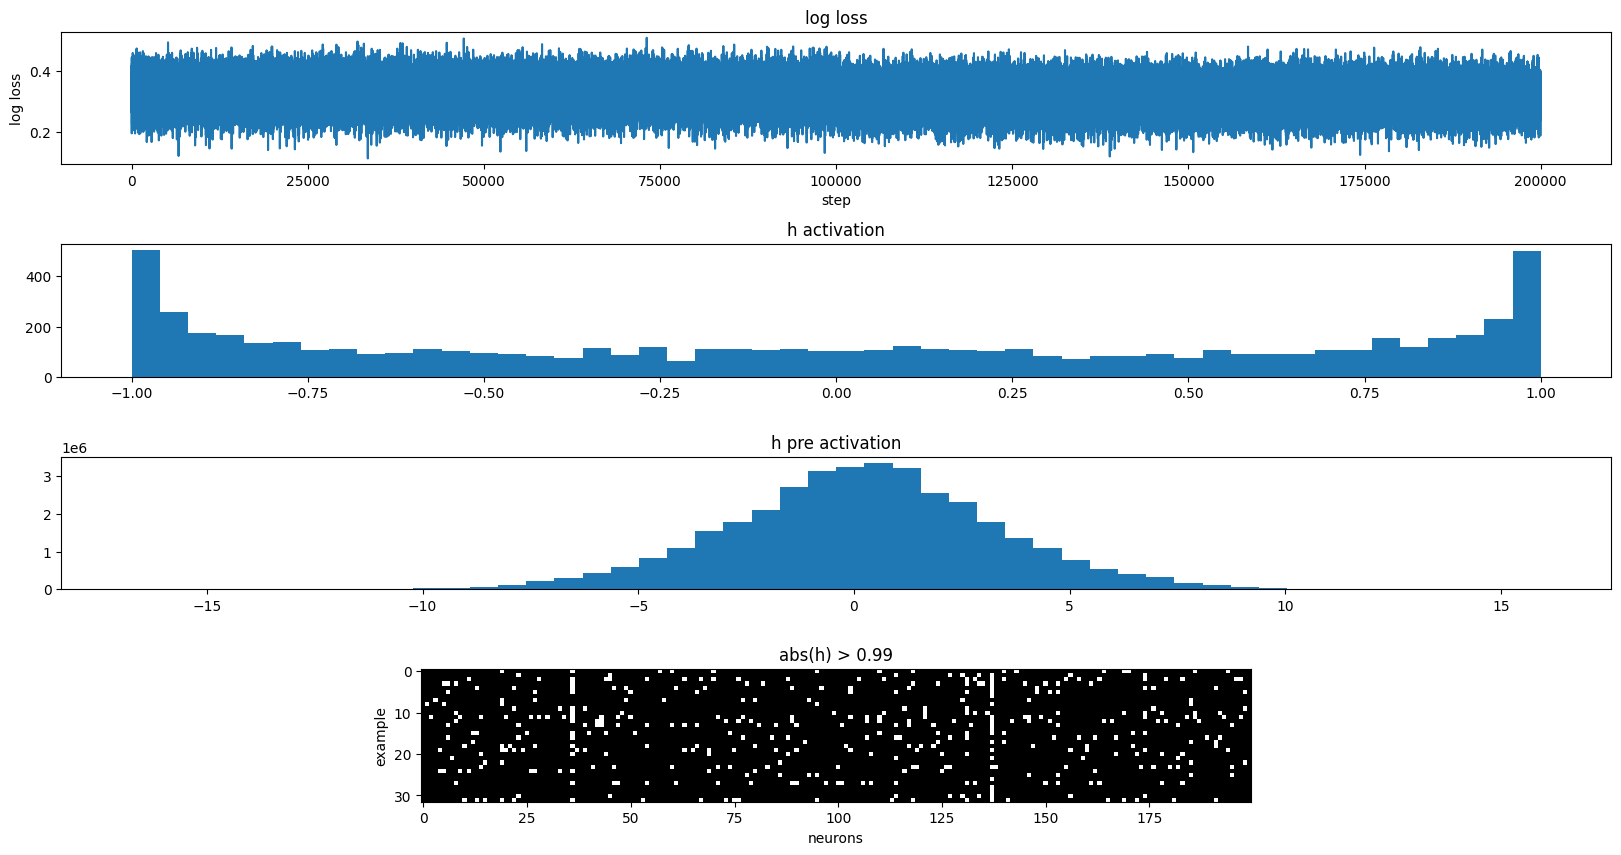

In [141]:
print(f'{h.shape=}')
print(f'{h.min()=}')
print(f'{h.max()=}')

fig, axes = plt.subplots(4, 1, figsize=(20,10))
plt.subplots_adjust(hspace=0.6)
axes[0].plot(stepi, lossi)
axes[0].set_xlabel("step")
axes[0].set_ylabel("log loss")
axes[0].set_title("log loss")

axes[1].hist(h.view(-1).tolist(), 50)
axes[1].set_title('h activation')
print(f'\n{h.shape=}, {h.min()=}, {h.max()=}')  # 32 examples, 200 neurons for each example

axes[2].hist(hpreact.view(-1).tolist(), 50) # it is too large, too broad, too saturated, which means there is less training for the neurons, they activate less frequently
axes[2].set_title('h pre activation')

axes[3].imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest")  # a boolean tensor, white if true, black if false, 32 examples, 200 neurons
axes[3].set_title('abs(h) > 0.99')
axes[3].set_xlabel('neurons')
axes[3].set_ylabel('example')
# for any of these 200 neurons, if the whole column is white, then given the wieghts and baises, no single example ever activates this tanh in the active part of the tanh
# if all examples land in the tail, it is a dead neuron

In [142]:
# we can calibrate the batch norm at the end of the training
# this step is only needed if we are not calculating the bnmean_running and the bnstd_running during training
with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 #+ b1
    # measure the mean/std over the entire training set, do this one single time
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)
    # these will be fixed tensors now, and can now be used during inference

print("explicityly getting bnmean and bnstd post training")
print(f'{bnmean}')
print(f'{bnstd}')

print("when calculated during training instead")
print(f'{bnmean_running}')
print(f'{bnstd_running}')
# values should be close
print(f'{torch.allclose(bnmean, bnmean_running, atol=0.1)=}')
print(f'{torch.allclose(bnstd, bnstd_running, atol=0.1)=}')


explicityly getting bnmean and bnstd post training
tensor([[-3.0044e+00,  7.1640e-01, -1.7933e+00,  1.9959e+00,  1.0177e+00,
          1.7748e+00,  1.8348e+00, -2.6689e+00,  1.2677e+00,  1.1236e+00,
         -1.9163e+00, -3.5088e+00,  2.2254e-01, -9.9625e-01,  6.8052e-01,
         -1.0608e+00,  7.2435e-01, -2.0992e+00, -6.1016e-02,  1.8028e+00,
         -1.6757e+00, -3.5282e-02, -2.2586e-01,  2.1860e-01,  1.6126e+00,
          2.4917e+00,  1.4121e+00,  1.2059e+00,  5.3252e-01,  2.3256e+00,
          1.8445e-01, -1.6120e+00, -2.3034e-01, -5.9241e-01, -4.8152e-01,
         -2.0963e+00, -3.2805e+00, -2.4125e-02,  2.7246e-01,  1.1838e+00,
         -5.3100e-01, -1.2427e+00,  1.3620e-01, -2.5947e-01,  4.4364e-01,
          1.3319e+00,  2.0703e+00, -3.6346e-01,  2.5472e+00,  1.0046e+00,
          2.7813e+00, -1.3790e+00,  2.8259e+00, -2.8080e-01,  4.8646e-01,
         -2.6069e+00,  9.0917e-02,  7.2339e-01,  9.8956e-01, -7.1908e-01,
         -8.8553e-01,  1.8518e+00,  4.6816e-01,  8.5664e-01, 

In [143]:
# evaluation
@torch.no_grad()  # this decorator disables gradient tracking on this function
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': {Xdev, Ydev},
        'test': {Xte, Yte},
    }[split]
    emb = C[x]  # [N, block_size, n_embd]
    embcat = emb.view(emb.shape[0], -1)  # concat into (N, block_size * n_enbd)
    hpreact = embcat @ W1 #+ b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running  + bnbias
    h = torch.tanh(hpreact)  # (N, n_hidden)
    logits = h @ W2 + b2  # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0510761737823486
val 2.0987465381622314


In [144]:
# sample from the model
def sample_model(num_sample_names):
    g = torch.Generator().manual_seed(2147483647 + 10)

    for _ in range(num_sample_names):
        out = []
        context = [0] * block_size # init with all ...
        while True:
            # forward pass the neural net
            emb = C[torch.tensor([context])]  # (1, block_size, n_embd)
            h = torch.tanh(emb.view(1, -1) @ W1 )#+ b1)
            logits = h @ W2 + b2
            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1, generator=g).item()
            context = context[1:] + [ix]
            out.append(ix)
            if ix == 0:
                break
        print(''.join(itos[i] for i in out))

num_sample_names = 20
sample_model(num_sample_names)

cathlizabbillpkfisrishristyviahfyansja.
bnixfarwyyrt.
kaedix.
quinithziriavivanekyah.
blgistutefflnishlistan.
vabbigabriff.
jarixexfknessirstimesticoishgttsleynardhamaskmisrissyahshmariozswuf.
jesvalairahnakaylahnn.


mazobbertsramsryahramskemtrryah.
xeinaodusly.
blds.
truquintonbesphrudrprissslytte.
conzahmmyghn.
khlbsesdan.
kzamdyev.
bly.
qoyyah.
rowk.
kaimkoiorgracielsinszesmanxellistimercsslytth.
yobadyselisabbigryffiyohnm.


# EAMPLE: RESNET
- resnet is used to predict pictures, this is a deep neural network
- uses Bottlneck blocks - https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py#L108 
- Bottlenext init function initializes all the parameters
- Bottlenext forward does the forward pass and batch normalization
- there are convolutional layers (which are used for images) doing wx + b on overlapping patches of the input image
- the nonlinearity layer is relu which is better for large networks
- same pattern - linear layer, batch normalization, non linearity layer
- thats the motif when stacking up deep neural networks

# LAYERS
- linear layer - https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear
- $y = wx + b$ where $x$ is A_transpose
- parameters - fan in and fan out to know how big the weight matrix should be, needs also bias boolean, set to False if following this layer by a batch normalization layer
- vars - weight and bias, by default, weights scale init by 1 / sqrt of fan in using a uniform distribution (not gaussian), this will ensure a roughly gaussian output
- batch norm 1d - https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html#torch.nn.BatchNorm1d
- params - needs number of features, 200 in our case, epsilon default to 1^-5, momentum (used for running mean and std dev (0.001 in ex above)), affine (almost always True), track_running_stats (False if want to do it post training), device (cpu or gpu), dtype
- momentum should be slightly higher for large batch sizes, but if only 32 examples, 0.001 should be good enough and 0.1 might be quite dangerous and won't converge priberly 

In [146]:
# let's torchify the code!
class Linear:

    # torch linear layer also has device and dtype as input parameters here
    # fan in and fan out are the number of inputs and number of outputs
    # self.weight is init typically by randn and devided by fan_in**05
    def __init__(self, fan_in, fan_out, bias=True):  
        # if using batchnorm in model pattern, we don't necessarily even have to normalize by fan_in sometimes
        # take out fan_in and self.weight is just random gaussian
        self.weight = torch.randn((fan_in, fan_out), generator=g) #/ fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    # calling this layer does essentially w*x + b
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
# similar to pytorch batch norm 1d layer
# see equation there - https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html#torch.nn.BatchNorm1d
# track_running_stats is True by deafult
# device is cpu by default and dtype is float by default
class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        # pytorch nn modules also has the training variable, because the layer behavior is dffierent whether you are training or testing or inferencing 
        # this defaults to True
        self.training = True  
        # parameters (trained with backprop) - these are learnable parameters
        self.gamma = torch.ones(dim)  # like batch norm gain, set to ones by default
        self.beta = torch.zeros(dim)  # like batch norm bias, set to zeros by default
        # buffers (trained with a running 'momentum update'), not part of gradient descent, not part of parameters, only trained internally
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)  # batch mean
            xvar = x.var(0, keepdim=True, unbiased=True)  # batch variance, this is the std dev sqaured
        else:  # we are testing/inferencing
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # normalize to unit variance
        self.out = self.gamma * xhat + self.beta  # calculating output of layer, pytorch does not have self.out
        # update the buffers
        if self.training:
            with torch.no_grad():  # this is a context manager, we prevent torch from creating a computational graph here
                # this will make it more efficient and avoid using unnecessary memory
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []
    
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 100  # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)

# now that we have layers, we can easily stack them into a list, into a 6 layer multi layer perceptron!!!! MLP
# why do we need tanh layer and then have to worry about the gain?
# a massive linear sandwich (only linear layers) will collapse into a linear function, no matter how many linear functions you stack up, aka large wx+b
# look up papers for inifintiely linear layer models
C = torch.randn((vocab_size, n_embd), generator=g)  # C is the embedding matrix
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(), 
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size),  BatchNorm1d(vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    # this artifically makes values in the corresponding tensor way too low
    # which results in a high update to data ratio for its parameter
    # for model with all linear layers or linear tanh layer sandwich, use the following:
    #layers[-1].weight *= 0.1
    # for model with linear, batchnorm, tanh sandiwch, use the following
    # because in batchnorm, gamma acts as multiplier to xhat
    layers[-1].gamma *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            # 5/3 is a good gain for a sandwich of linear and tanh layers
            # without batchnorm, we have to carefully set these gains to get nice activations in both forward and backward pass
            # 1 is a good gain if model is all linear layers
            # this will cause statistics for forward and backward pass to be well behaved
            # using model with linear, batchnorm, tanh pattern makes this gain a lot less brittle
            layer.weight *= 5/3 

# notice the double list comprehension
# for every layer in layers
# and for every parameter in the layer
# we are stacking up the parameters
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

47551


In [147]:
# same optimization
max_steps = 200000
batch_size = 32
lossi = []
ud = []  # update to data ratio

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X, Y 

    # forward pass
    emb = C[Xb]   # embed the characters into vectors
    x = emb.view(emb.shape[0], -1)  # concatenate the vectors
    for layer in layers:  # linear application of the layers
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad()  # AFTER DEBUG: take out retain_grad
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 1000 == 0:  # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        # for every parameter, get update std dev divided by actual content data std dev
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        break  # remove AFTER DEBUG to run full optimization



      0/ 200000: 3.2870
   1000/ 200000: 2.5429


activation distribution
layer 2 (      Tanh): mean -0.00, std: 0.63, saturated: 2.62%
layer 5 (      Tanh): mean +0.00, std: 0.63, saturated: 2.62%
layer 8 (      Tanh): mean -0.00, std: 0.64, saturated: 2.38%
layer 11 (      Tanh): mean -0.00, std: 0.64, saturated: 2.75%
layer 14 (      Tanh): mean +0.00, std: 0.63, saturated: 2.69%

backward pass - gradient distribution
layer 2 (      Tanh): mean +0.000000, std: 3.059681e-03
layer 5 (      Tanh): mean +0.000000, std: 2.592222e-03
layer 8 (      Tanh): mean -0.000000, std: 2.344924e-03
layer 11 (      Tanh): mean -0.000000, std: 2.194399e-03
layer 14 (      Tanh): mean -0.000000, std: 1.853027e-03

weights
weight   (27, 10) | mean +0.000000 | std 6.574890e-03 | grad:data ratio 6.569359e-03
weight  (30, 100) | mean -0.000003 | std 1.222243e-03 | grad:data ratio 7.155376e-04
weight (100, 100) | mean +0.000008 | std 6.805561e-04 | grad:data ratio 4.096763e-04
weight (100, 100) | mean +0.000002 | std 5.689897e-04 | grad:data ratio 3.38918

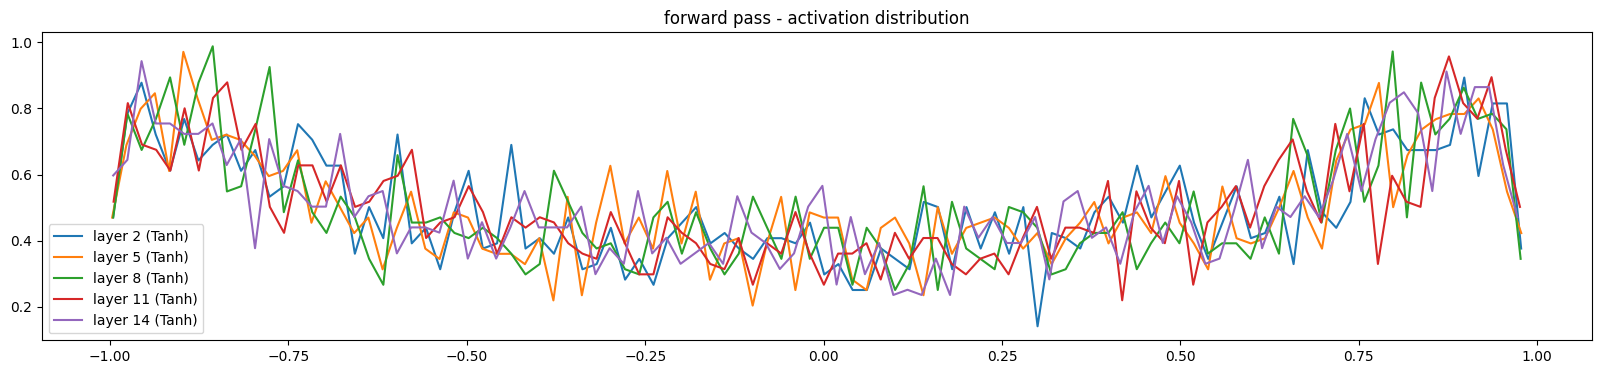

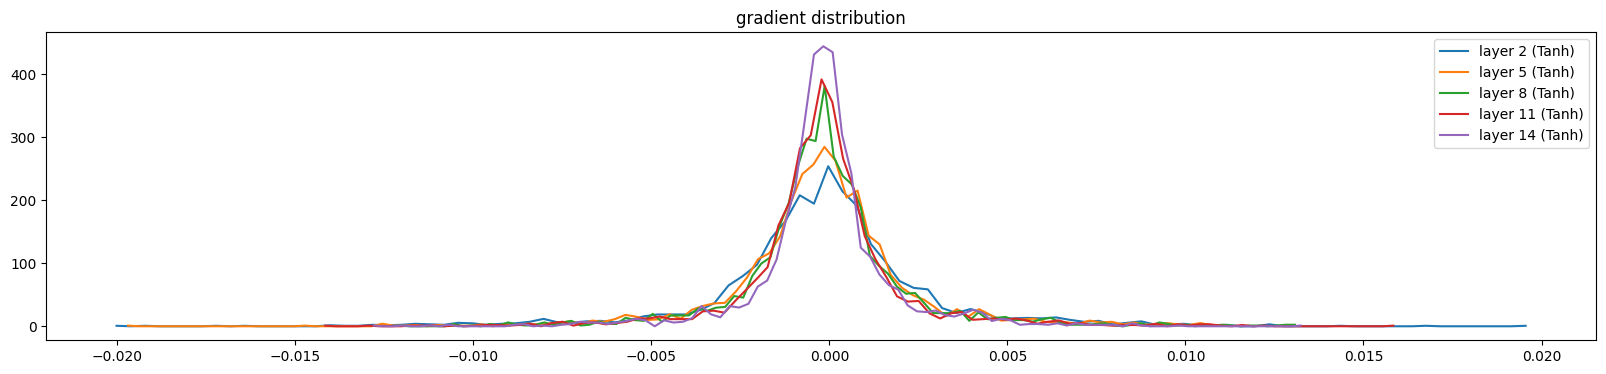

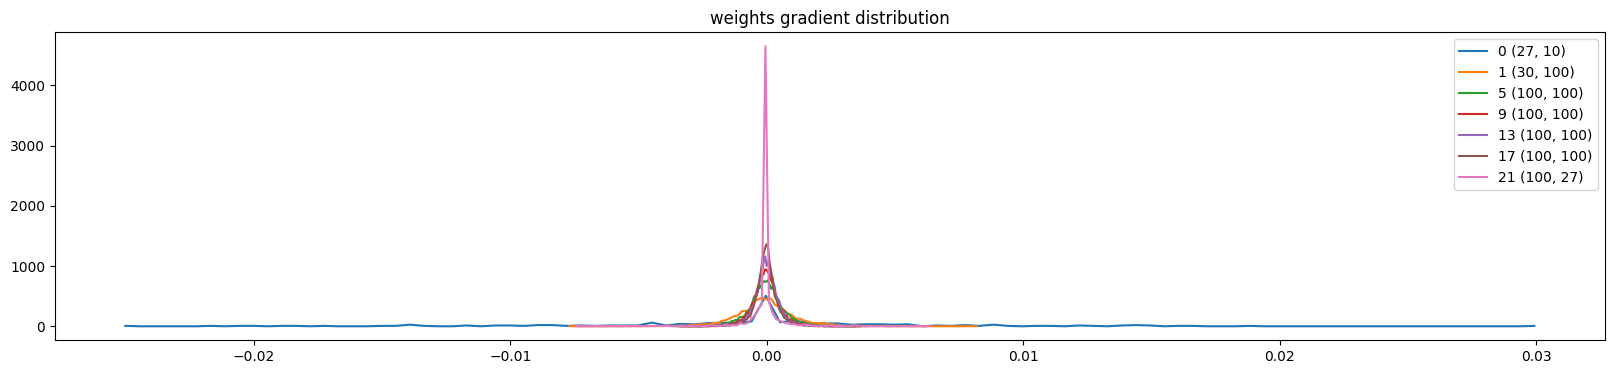

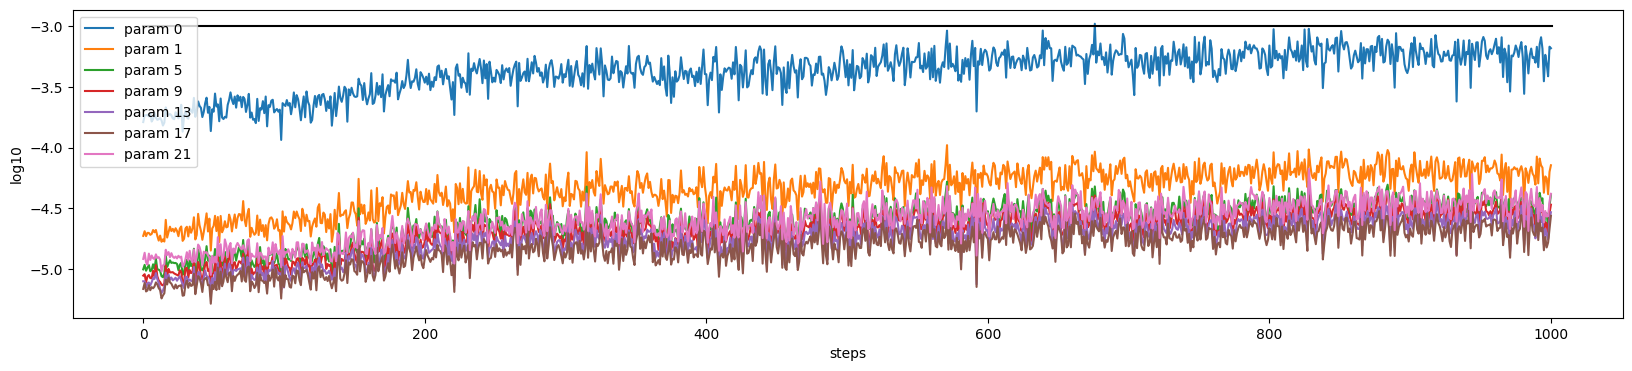

In [148]:
# visualize histograms
# see the forward pass
print("activation distribution")
plt.figure(figsize=(20,4))  # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]):  # note: exclude the output layer, the last one is just the softmax layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std: %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('forward pass - activation distribution')
print()
# we don't want percent saturated to be too high, that means we are at the tails of the graients
# for each layer we will look at how many values in these tensors take on any of the values in this axis below
# plot shows that the first layer is saturated, and subsequent layers stabilize at around a stddev of 0.65 and a saturation of about 5%
# this is because we initialized all the linear layers weights by 5/3
# try removing that gain and rerunning this
# this will show that the std dev is shrinking and the saturation is going down to 0, this shows that the layers are shrinking down to zero, slowly
# the reason for that is that when you have a sandwich of linear layers alone interpersed with tanh, tanh is a squashing function, so some gain is necessary to fight the squashing

# see the backward pass
# let's do the same with the gradients
print("backward pass - gradient distribution")
plt.figure(figsize=(20,4))  # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]):  # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std: %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('gradient distribution')
print()

# let's look at parameters, their values and their gradients
# let's restrict to the 2 dimensions of the parameters, aka the weights of the linear layers
# skipping bias, gamma, beta, batch norm, etc....
print("weights")
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        # grad:data ratio gives you scale of gradient compared to scale of actual values
        # if grad numbers are too large compared to numbers in data, we are in trouble
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution')
print()
# see that the last layer is the trouble maker, takes on values that are much larger than values inside the neural net
# see std dev how it blows up for the last layer, 10 times greater than for all the other weights in the neural net
# this fixes itself if you train for a bit longer
# grad:data ratio is not actually that informative, the update to the ratio is what matters

print("update to data ratio")
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:  # constrain to just the weights
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.ylabel('log10')
plt.xlabel('steps')
plt.plot([0, len(ud)], [-3, -3], 'k')  # these ratios should be~1e-3, indicate on plot
plt.legend(legends)
# values below -3 indicate parameters are not training fast enough
# test this, update the learning rate to 0.001 something really small, and you'll see
# in this plot that the updates are way too small, mostly below the -3 line
# that would indicate a sympton of training way too slow
# you should be near -3 and not much more above that